In [1]:
import dgl
import dgl.function as fn
import torch.nn.functional as F
from dgl import DGLGraph
import time
from dgl.data import citation_graph as citegrh
from scipy import sparse
from sklearn import preprocessing 
from tqdm import tqdm
import networkx as nx
import geopandas as gpd
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import math
import random
import community
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from modularity_maximization import partition
device = torch.device('cpu')

Using backend: pytorch


In [2]:
sample_num = 2000

### Graph Construction —— Population Flow

In [3]:
# 确认节点数量
bs_gpd = gpd.read_file('../../data/basestation-gis/basestation_aggregation.shp')
bs_gpd = bs_gpd.iloc[:sample_num:, ::]
bs_num = bs_gpd.shape[0]

# 构造图节点
nodes_list = list(range(bs_num))
G = nx.Graph()
G.add_nodes_from(nodes_list)

# 读取邻接矩阵adjacent
# 以工作日(周一)的早高峰时段为例
adj = pd.read_csv('../../data/adj/adj_20151109_0002.csv')
adj = adj.iloc[:, 1:].values
adj = adj[:sample_num:, :sample_num:]
adj = adj + adj.T
for i in range(sample_num): adj[i, i] = 0
    
# for i in range(bs_num):
#     if (adj[i]==0).all():
#         adj[i, :] = 0.0001
#         adj[:, i] = 0.0001

# D_12 = np.diag(np.power(np.sum(adj, axis=0)+0.00001, -1/2))
# adj_norm = np.dot(np.dot(D_12, adj), D_12)

for i in tqdm(range(bs_num)):
    for j in range(bs_num):
        tmp = adj[i, j]
        if tmp>0: G.add_edge(i, j, weight=tmp)

100%|██████████| 2000/2000 [00:03<00:00, 575.15it/s]


### Graph Construction —— Geographic Reachability

### Feature Construction —— Equality Contribution

In [4]:
feature = pd.read_csv('../../data/features/features_wf_new.csv')
feature = feature.iloc[:, 1::].values

In [5]:
feature = feature[:sample_num:, :]

### Net Initial 

np.identity()只能创建方阵，np.eye()可以创建一般矩阵，主对角线为1，其余元素为0。

In [6]:
clusters_number = 15

In [7]:
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

A = torch.from_numpy(adj).float()

DG1 = dgl.DGLGraph()
DG1.from_networkx(G)
features = torch.from_numpy(feature).float()

# D_ = th.diag(th.pow(d.view(-1), -1/2))
# A_norm = th.mm(th.mm(D_, A), D_)

# k = 15
in_dim = features.size()[1]
out_dim = clusters_number

In [8]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

In [9]:
class GCN_model(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCN_model, self).__init__()
        self.layer = GCNLayer(in_feats, out_feats)
        # self.B = B

    def forward(self, g, features, beta):
        global gcn_output
        n = nn.Softmax(dim=1)
        
        gcn_output = self.layer(g, features)
        weight_feature = n(gcn_output)
        W_noise = torch.div(torch.exp(weight_feature)-1, torch.exp(weight_feature)+1)*beta
        return W_noise

In [46]:
# clusters_number = 15

class GCN_prior(nn.Module):
    def __init__(self, A_hat, num_node, num_feat, num_cluster):
        super(GCN_prior, self).__init__()
        self.num_node = num_node # 特征数 f
        self.num_feat = num_feat
        self.num_cluster = num_cluster # 隐含数 h
        self.A_hat = A_hat
        self.d = torch.tensor(list(dict(G.degree()).values()), dtype=np.float).contiguous().view(-1, 1)
        self.ddT = torch.mm(self.d, self.d.T)
        self.B = (self.A_hat - torch.div(self.ddT, torch.norm(self.A_hat, p=1))).float()
        self.B_norm = torch.div(self.B, torch.norm(self.A_hat, p=1))
        self.W_0 = nn.Parameter(torch.ones(num_node, num_cluster)) # [1][f*h]
        self.layer = GCNLayer(num_feat, num_cluster)

    def forward(self, X, DG, temp, epoch): # X貌似暂时没有用到
        global featureSelector # 
        global weight_feature # 
        # f = nn.Softmax(dim=1)
        gcn_output = self.layer(DG, X)
        featureSelector = self.W_0 + gcn_output # [1][f*h]
        results = torch.zeros(self.W_0.size()) # [0][f*h]
        x = 1*(epoch+1) # x次取平均,目测这个目的是为了稳定。
        for i in range(x):
            # logits --> self.W_0: [batch_size, num_features] 非规范化对数概率
            # tau: 非负的对抗强度。
            # hard: 如果 True, 返回的样本将会离散为 one-hot 向量
            results += F.gumbel_softmax(featureSelector,tau=temp,hard=False)
        weight_feature = results/x # [-][f*h]

        # H = torch.mm(torch.mm(weight_feature.T, B), weight_feature) # weight_feature 就是我们要求的U
        H = torch.mm(torch.mm(weight_feature.T, self.B_norm), weight_feature) # weight_feature 就是我们要求的U
        Hh = torch.div(H, H.sum(axis=0)) # 按照每一列进行归一化，列为axis=0的方向。
        m = nn.Softmax(dim=0)
        return m(Hh)

In [50]:
class Gumbel(nn.Module):
    def __init__(self, A_hat, num_feat, num_hidden, W_prior):
        super(Gumbel, self).__init__()
        f = nn.Softmax(dim=1)
        self.num_feat = num_feat # 特征数 f
        self.num_hidden = num_hidden # 隐含数 h
        self.A_hat = A_hat
        self.d = torch.tensor(list(dict(G.degree()).values()), dtype=np.float).contiguous().view(-1, 1)
        self.ddT = torch.mm(self.d, self.d.T)
        self.B = (self.A_hat - torch.div(self.ddT, torch.norm(self.A_hat, p=1))).float()
        self.B_norm = torch.div(self.B, torch.norm(self.A_hat, p=1))
        self.W_0 = nn.Parameter(f(torch.ones(num_feat, num_hidden)+W_prior)) # [1][f*h]

    def forward(self, temp, epoch): # X貌似暂时没有用到
        global featureSelector # 
        global weight_feature # 
        featureSelector = self.W_0 # [1][f*h]
        results = torch.zeros(self.W_0.size()) # [0][f*h]
        x = 1*(epoch+1) # x次取平均,目测这个目的是为了稳定。
        for i in range(x):
            results += F.gumbel_softmax(self.W_0, tau=temp, hard=False)
        weight_feature = results/x # [-][f*h]

        H = torch.mm(torch.mm(weight_feature.T, self.B_norm), weight_feature) # weight_feature 就是我们要求的U
        Hh = torch.div(H, H.sum(axis=0)) # 按照每一列进行归一化，列为axis=0的方向。
        m = nn.Softmax(dim=0)
        return m(Hh)

In [12]:
def lossFn(output): 
    return torch.trace(-torch.log(output))

### Prior Training

In [14]:
num_node = len(G.nodes()) # f = 节点数
num_feat = features.size()[1]
num_cluster = clusters_number # h = 聚类数

model_base = GCN_prior(torch.tensor(A).float().clone(), num_node, num_feat, num_cluster).to(device)

optimizer_base = optim.Adam(model_base.parameters(),lr=1.5e-2)

loss_hist = []
modularity_hist = []
temp = 3
beta = 0.001
epoch_prior_num = 500

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [15]:
for epoch in range(epoch_prior_num):
    model_base.train()
    model_base.zero_grad()
    if(epoch == 75):
        temp = 2.75
    elif(epoch == 100):
        temp = 2.5
    elif(epoch == 125):
        temp = 2
    elif(epoch == 150):
        temp = 1.8
    elif(epoch == 175):
        temp = 1.25
    elif(epoch == 250):
        temp = 1.00
    elif(epoch == 300):
        temp = 0.75
    elif(epoch == 320):
        temp = 0.50
    elif(epoch == 400):
        temp = 0.20
    output = model_base(features, DG1, temp, epoch)
    ###############################################
    loss = lossFn(output)
    loss_hist.append(loss.item())
    ###############################################
    if epoch%20==0: 
        gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
        labels_pred = gumbel_matrix.data.numpy()
        modu = community.modularity(dict(zip(list(range(len(labels_pred))), labels_pred)), G, weight='weight')
        modularity_hist.append(modu)
        print('Epoch: ', epoch, '; Loss: ', round(loss.item(), 4), '; Modulariy: ', round(modu, 4))
    loss.backward()
    optimizer_base.step()
    
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()
modu = community.modularity(dict(zip(list(range(len(labels_pred))), labels_pred)), G, weight='weight')
modularity_hist.append(modu)
print('Epoch: ', epoch, '; Loss: ', round(loss.item(), 4), '; Modulariy: ', round(modu, 4))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Epoch:  0 ; Loss:  40.6209 ; Modulariy:  0.0072
Epoch:  10 ; Loss:  40.6207 ; Modulariy:  -0.0118
Epoch:  20 ; Loss:  40.62 ; Modulariy:  0.0121
Epoch:  30 ; Loss:  40.6183 ; Modulariy:  0.0425
Epoch:  40 ; Loss:  40.6137 ; Modulariy:  0.0974
Epoch:  50 ; Loss:  40.6042 ; Modulariy:  0.175
Epoch:  60 ; Loss:  40.5873 ; Modulariy:  0.216
Epoch:  70 ; Loss:  40.5607 ; Modulariy:  0.2502
Epoch:  80 ; Loss:  40.5078 ; Modulariy:  0.2693
Epoch:  90 ; Loss:  40.4533 ; Modulariy:  0.3037
Epoch:  100 ; Loss:  40.3468 ; Modulariy:  0.3124
Epoch:  110 ; Loss:  40.2571 ; Modulariy:  0.3623
Epoch:  120 ; Loss:  40.1571 ; Modulariy:  0.349
Epoch:  130 ; Loss:  39.8511 ; Modulariy:  0.3766
Epoch:  140 ; Loss:  39.6856 ; Modulariy:  0.4263
Epoch:  150 ; Loss:  39.3689 ; Modulariy:  0.44
Epoch:  160 ; Loss:  39.14 ; Modulariy:  0.4499
Epoch:  170 ; Loss:  38.9002 ; Modulariy:  0.4574
Epoch:  180 ; Loss:  38.1254 ; Modulariy:  0.4599
Epoch:  190 ; Loss:  37.7417 ; Modulariy:  0.4704
Epoch:  200 ; Loss:

In [16]:
partition = weight_feature.detach().max(dim=1)[1].data.numpy()
partition = dict(zip(range(len(partition)), partition))

alpha = 2
W_prior = np.zeros((bs_num, clusters_number))
for key, value in partition.items():
    try:
        W_prior[key, value] = alpha
    except:
        pass

### Partition Process

In [ ]:
model = Gumbel(torch.tensor(A).float().clone(), num_node, num_cluster, torch.tensor(W_prior).float().clone()).to(device)

loss_hist = []
modularity_hist = []
temp = 3

In [59]:
optimizer = optim.Adam(model.parameters(),lr=1e-2)

for epoch in range(350):
    model.train()
    model.zero_grad()
    if(epoch == 75):
        temp = 2.75
    elif(epoch == 100):
        temp = 2.5
    elif(epoch == 125):
        temp = 2
    elif(epoch == 150):
        temp = 1.8
    elif(epoch == 175):
        temp = 1.25
    elif(epoch == 250):
        temp = 1.00
    elif(epoch == 300):
        temp = 0.75
    elif(epoch == 320):
        temp = 0.50
    elif(epoch == 400):
        temp = 0.20
    output = model(temp, epoch)
    ############################################
    loss = lossFn(output)
    loss_hist.append(loss.item())
    ############################################

    
    if epoch%10==0: 
        gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
        labels_pred = gumbel_matrix.data.numpy()
        modu = community.modularity(dict(zip(list(range(len(labels_pred))), labels_pred)), G, weight='weight')
        modularity_hist.append(modu)
        print('Epoch: ', epoch, '; Loss: ', round(loss.item(), 4), '; Modulariy: ', round(modu, 4))
    loss.backward()
    optimizer.step()
    
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()
modu = community.modularity(dict(zip(list(range(len(labels_pred))), labels_pred)), G, weight='weight')
modularity_hist.append(modu)
print('Epoch: ', epoch, '; Loss: ', round(loss.item(), 4), '; Modulariy: ', round(modu, 4))

Epoch:  0 ; Loss:  31.9195 ; Modulariy:  0.5488
Epoch:  10 ; Loss:  31.9195 ; Modulariy:  0.5488
Epoch:  20 ; Loss:  31.9195 ; Modulariy:  0.5488
Epoch:  30 ; Loss:  31.9195 ; Modulariy:  0.5488


KeyboardInterrupt: 

In [33]:
partition = weight_feature.detach().max(dim=1)[1].data.numpy()
partition = dict(zip(range(len(partition)), partition))

alpha = 2
W_prior = np.zeros((bs_num, clusters_number))
for key, value in partition.items():
    try:
        W_prior[key, value] = alpha
    except:
        pass

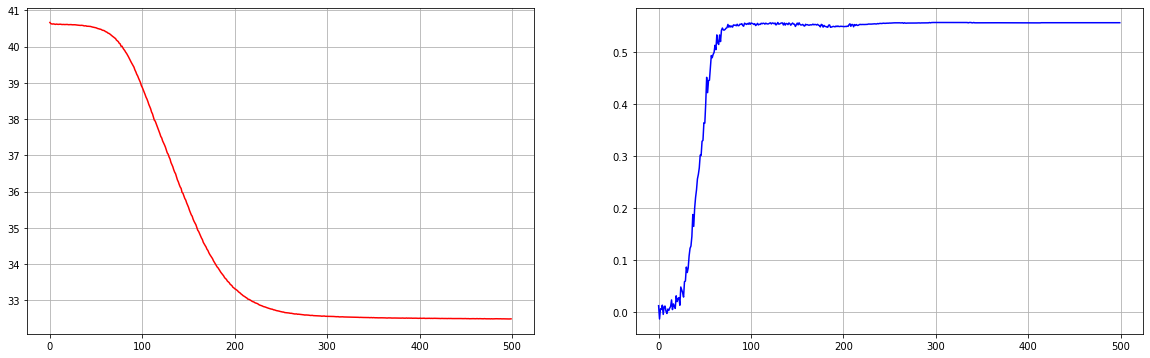

torch.Size([2000, 15])


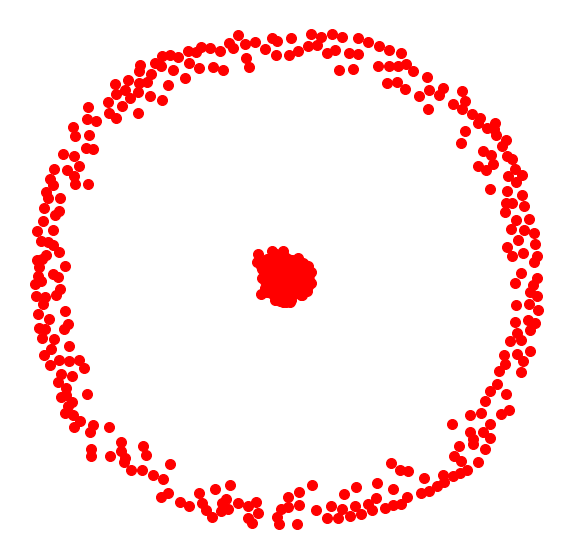

0.5569713287950876


In [160]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, color='red')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(modularity_hist, color='blue')
plt.grid(True)
plt.show()

print(weight_feature.detach().size())
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=100, node_color="r", with_labels=False)
options = {
    'node_color': 'red',
    'node_size': 10,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.show()

print(max(modularity_hist))